In [295]:
import pandas as pd
import json
import os.path
import matplotlib.pyplot as plt
import collections
import matplotlib as mpl
import copy
import seaborn as sns
import re
import numpy as np
import os
from datetime import datetime

In [2]:
def maybe_parse_time(str):
    try:
        return datetime.strptime(str, '%H:%M:%S.%f')
    except ValueError:
        return False

In [3]:
maybe_parse_time('16:12:12.228744')

datetime.datetime(1900, 1, 1, 16, 12, 12, 228744)

In [4]:
def parse_call_time(line):
    matches = re.findall('([^ ]+) time: ([0-9]+) ?nanoseconds\s*',line)
    if not matches:
        return False
    elif len(matches) != 1 or len(matches[0]) != 2:
        raise Exception('Uh oh! ' + line, matches)
    
    (fname, ns) = matches[0]
    
    return (fname,int(ns))

In [11]:
def combine(raw_dir, csv_out):
    
    csvs = open(csv_out,'w')
    csvs.write('batch,version,case,local_seq,fname,ns\n')
    
    issues = open('issues.txt','w')
    any_issues = False
    
    for batch in os.listdir(raw_dir):
        if batch in ['scale', 'consistency']:
            continue
        for version in os.listdir(os.path.join(raw_dir,batch)):
            for case in os.listdir(os.path.join(raw_dir,batch,version)):
                filename = os.path.join(raw_dir,batch,version,case)
                file = open(filename,'r')
                
                lineno = 0
                local_seq = 0
                for line in file:
                    res = parse_call_time(line)
                    if not res:
                        if not line.startswith('Initializing') and not maybe_parse_time(line.strip()):
                            any_issues=True
                            issuestr = f'in {filename} SKIP [{lineno}]: {line[:-1]}'
                            print(issuestr)
                            issues.write(issuestr+'\n')
                        lineno += 1
                        continue
                    lineno += 1
                    (fname,ns) = res
                    
                    csvs.write(f'{batch},{version},{case},{local_seq},{fname},{ns}\n')
                    
                    local_seq+=1
    if any_issues:
        print('Some parsing issues!')
    else:
        print('No parsing issues :)')
        

In [12]:
combine('../output','results1.csv')

No parsing issues :)


In [13]:
df = pd.read_csv('results1.csv')

In [14]:
df

,batch,version,case,local_seq,fname,ns
0,read-perf,basic,256_KB,0,getattr,2044215
1,read-perf,basic,256_KB,1,getattr,1638412
2,read-perf,basic,256_KB,2,getattr,1457311
3,read-perf,basic,256_KB,3,getattr,1442209
4,read-perf,basic,256_KB,4,getattr,1818411
...,...,...,...,...,...,...
56647,write-perf,perf,64_B,898,getattr,1649719
56648,write-perf,perf,64_B,899,read,2900
56649,write-perf,perf,64_B,900,write,7147882
56650,write-perf,perf,64_B,901,release,5000


In [15]:
faceted = df.drop('local_seq',axis=1).groupby(['batch','version','case','fname'])

In [16]:
faceted.mean().to_csv('mean.csv')
faceted.min().to_csv('min.csv')
faceted.max().to_csv('max.csv')
faceted.median().to_csv('median.csv')
faceted.std().replace(np.nan,0).to_csv('sd.csv') # some tests don't have a mknod

In [264]:
def add_case_num(df):
    vals = ['64_B', '4_KB', '256_KB', '16_MB', '1_GB']
    return df.assign(case_num= df['case'].apply(vals.index))
    
def select_relevant(df,batch,fname):
    return df[np.logical_and(df['batch']==batch, df['fname']==fname)].drop(['batch','fname'],axis=1)

    return df[df[colname]==value]

def extract_first_calls(dataset, fname):
    def theta(group):
        i = group.local_seq.argmin()
        return group.index.get_level_values(0)[i]
    
    target = dataset[dataset['fname']==fname]
    grouped = target.groupby(['batch','version','case'])
    idx = grouped.apply(theta).to_numpy()
    
    return df.iloc[idx,:]
    
def extract_second_calls(dataset, fname):
    def theta(group):
        i = group.local_seq.argmin()
        return group.index.get_level_values(0)[i+1]
    
    target = dataset[dataset['fname']==fname]
    grouped = target.groupby(['batch','version','case'])
    idx = grouped.apply(theta).to_numpy()
    
    return df.iloc[idx,:]

def add_log_ns(df):
    return df.assign(log_ns=np.log(df.ns.to_numpy())).assign(ms = df.ns.to_numpy()*1e-6)
    
def extract_every_other_call(dataset,fname,offset=1):
    def theta(group):
        bys =  group.sort_values('local_seq')
        n = len(bys)
        ii = np.arange(offset,n,2)
        return list(group.index.get_level_values(0)[ii])
    
    target = dataset[dataset['fname']==fname]
    grouped = target.groupby(['batch','version','case'])
    indices = grouped.apply(theta)
    idx = np.concatenate(indices)
    return df.iloc[idx,:]

In [18]:
means = add_case_num(pd.read_csv('mean.csv'))
medians = add_case_num(pd.read_csv('median.csv'))
mins = add_case_num(pd.read_csv('min.csv'))

In [19]:
sns.set_theme()

In [101]:
firstopen = add_case_num(extract_first_calls(df,'open'))

(13.0, 23.0)

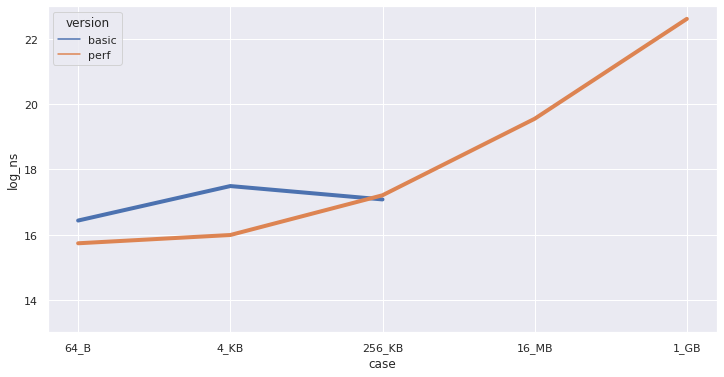

In [186]:
plt.figure(figsize=(12,6))
fig = sns.lineplot(data=add_log_ns(select_col_eq(firstopen,'batch','read-perf')).sort_values(['version','case_num']),x='case',y='log_ns',hue='version',linewidth=4)
fig.set_ylim(13,23)

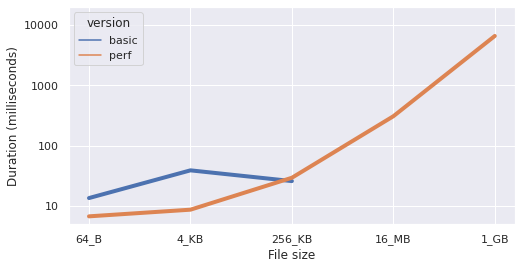

In [329]:
plt.figure(figsize=(8,4))
fig = sns.lineplot(data=add_log_ns(select_col_eq(firstopen,'batch','read-perf')).sort_values(['version','case_num']),x='case',y='ms',hue='version',linewidth=4)
plt.yscale('log')
fig.yaxis.set_major_formatter(mpl.ticker.LogFormatter())
fig.set_ylabel('Duration (milliseconds)')
fig.set_xlabel('File size')
fig.set_ylim(5,20000)
plt.show()
fig.figure.savefig("fig2.png",bbox_inches='tight')

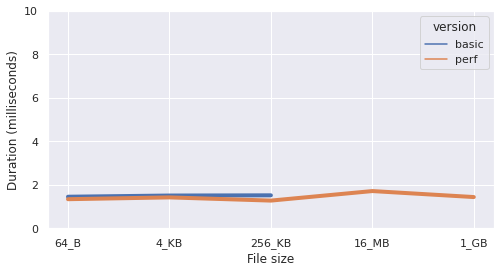

In [330]:
plt.figure(figsize=(8,4))
fig = sns.lineplot(data=add_log_ns(select_col_eq(select_col_eq(medians,'fname','open'),'batch','read-perf')).sort_values(['version','case_num']),x='case',y='ms',hue='version',linewidth=4)
fig.set_ylabel('Duration (milliseconds)')
fig.set_xlabel('File size')
fig.set_ylim(0,10)
plt.show()
fig.figure.savefig("fig3.png",bbox_inches='tight')

In [334]:
locky = select_col_eq(df,'batch','read-perf')
locky = extract_every_other_call(locky, 'open')

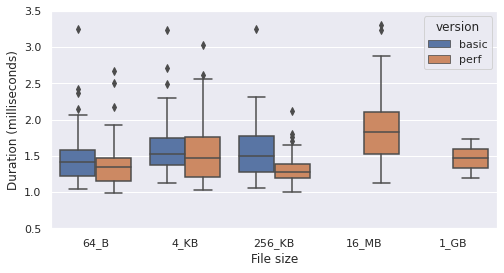

In [339]:
plt.figure(figsize=(8,4))
fig = sns.boxplot(data=add_log_ns(add_case_num(locky).sort_values(['version','case_num'])),x='case',y='ms',hue='version')
fig.set_ylabel('Duration (milliseconds)')
fig.set_xlabel('File size')
fig.set_ylim(0.5,3.5)
plt.show()
fig.figure.savefig("fig4.png",bbox_inches='tight')

In [ ]:
lucky = select_col_eq(df,'batch','write-perf')
lucky = extract_every_other_call(lucky,'release')

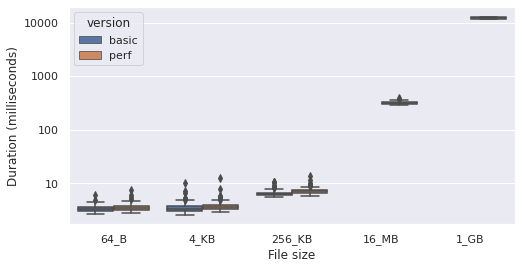

In [332]:
plt.figure(figsize=(8,4))
fig = sns.boxplot(data=add_log_ns(add_case_num(lucky).sort_values(['version','case_num'])),x='case',y='ms',hue='version')
plt.yscale('log')
fig.yaxis.set_major_formatter(mpl.ticker.LogFormatter())
fig.set_ylabel('Duration (milliseconds)')
fig.set_xlabel('File size')

plt.show()
fig.figure.savefig("fig5.png",bbox_inches='tight')